# RGI07 (Svalbard and Jan Mayen)

F. Maussion, Dec 2021

Goal: RGI6, except Jan Mayen

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist
import os

In [2]:
# Region of interest
reg = 7

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '07_rgi60_Svalbard.zip')

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + os.path.join(l2_dir, f'RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp'))

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
563,1583,33841.4,"Koenig, Nuth",Koenig,2012,"Svalbard, Jan Mayen, and Bouvet",2008,2000,2010
669,1565,25264.4,"Hagen, Kääb, Kohler, König, Moholdt, Nuth, Pet...",Nuth,2017,Svalbard,1966,1936,1971
670,1082,21844.0,"Hagen, Kääb, Kohler, König, Moholdt, Nuth, Pet...",Nuth,2017,Svalbard,1990,1961,1992
718,48,121.5,"Cogley, Hagen",Paul,2014,Randolph Glacier Inventory; Umbrella RC for me...,1975,1975,1975
720,84,117.5,Paul,Paul,2021,Various (GlobGlacier),2002,2002,2002


- 563 Seems to be RGI6
- 720 is an update from Frank on Jon Mayen

In [5]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [6]:
rgi_563 = shp.loc[shp.subm_id.isin([563])].copy()
rgi_563['is_rgi6'] = True
rgi_720 = shp.loc[shp.subm_id.isin([720])].copy()
rgi_720['is_rgi6'] = False

In [7]:
# Size filter?
needs_size_filter(rgi_563), needs_size_filter(rgi_720), 

(False, False)

In [8]:
# Read box for JonMayen
from utils import open_zip_shapefile
box = open_zip_shapefile(data_dir + f'/l0_support_data/JonMayen.zip')

Now we remove the glaciers from the box:

In [9]:
rp = rgi_563.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi_563.index

# Find non overlying polygons
difference = gpd.overlay(rp, box, how='difference')

# Create temporal variable
rgi_563 = rgi_563.loc[difference['orig_index']]

In [10]:
# Merge original RGI 580 (without the glacier in the box) and the RGI 729
rgi7 = pd.concat([rgi_563, rgi_720])

### Some sanity checks 

In [11]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
563,1583,1583
720,84,84


In [16]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

Orphan rock outcrops detected in subm_id [563.]


In [17]:
orphan_f = orphan_f.loc[orphan_f.subm_id == 563]
orphan_f['area'].sum() * 1e-6

0.3782274563294035

Ok, more details in the checks below.

### Plots 

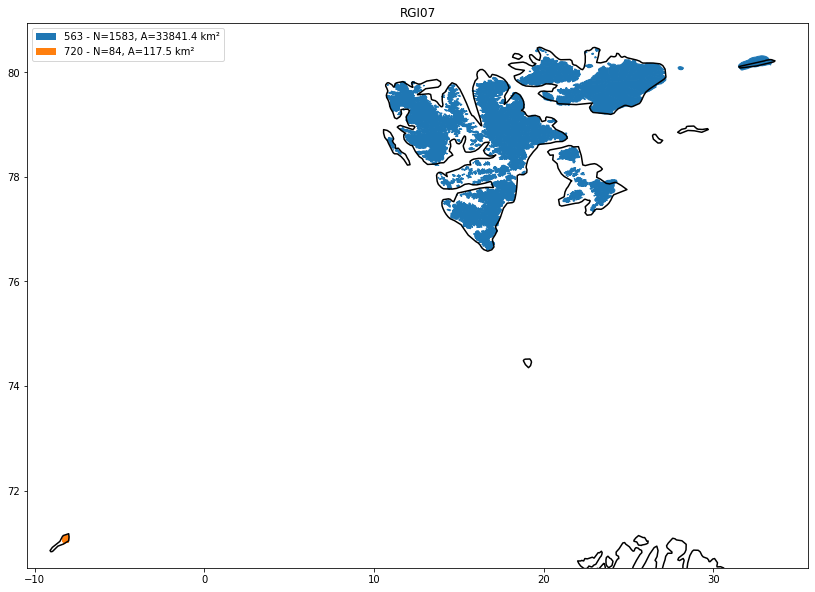

In [18]:
plot_map(rgi7, reg, loc='upper left')

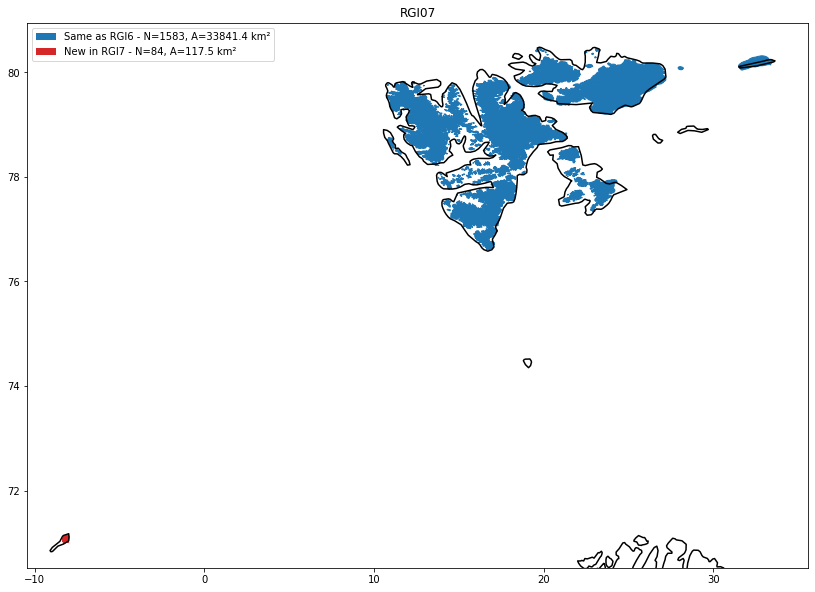

In [19]:
plot_map(rgi7, reg, loc='upper left', is_rgi6=True)

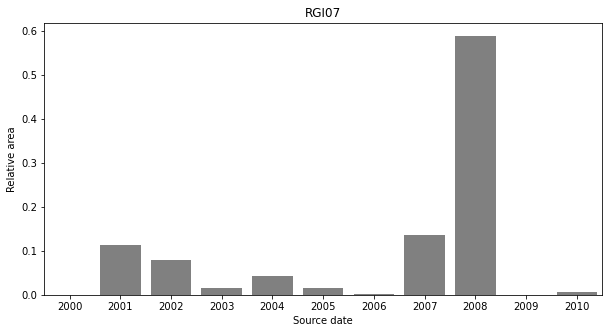

In [20]:
plot_date_hist(rgi7, reg)

### Text for github

In [21]:
fgh = sdf.T
fgh

subm_id,563,720
N,1583,84
A,33841.4,117.5
analysts,"Koenig, Nuth",Paul
submitters,Koenig,Paul
release_date,2012,2021
geog_area,"Svalbard, Jan Mayen, and Bouvet",Various (GlobGlacier)
src_date_mode,2008,2002
src_date_min,2000,2002
src_date_max,2010,2002


In [22]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 563                             | 720                   |
|:--------------|:--------------------------------|:----------------------|
| N             | 1583                            | 84                    |
| A             | 33841.4                         | 117.5                 |
| analysts      | Koenig, Nuth                    | Paul                  |
| submitters    | Koenig                          | Paul                  |
| release_date  | 2012                            | 2021                  |
| geog_area     | Svalbard, Jan Mayen, and Bouvet | Various (GlobGlacier) |
| src_date_mode | 2008                            | 2002                  |
| src_date_min  | 2000                            | 2002                  |
| src_date_max  | 2010                            | 2002                  |


## Write out and tar 

In [23]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI07.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI07'], returncode=0)


## Consistency check with RGI6 

In [24]:
# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')

In [25]:
# RGI6
rgi6 = open_zip_shapefile(rgi6_reg_file)
# FP
ref_fp = open_zip_shapefile(os.path.join(support_dir, 'c3s_gi_rgi07_L7_2002_v1.zip'))

In [26]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 
ref_fp['area'] = ref_fp.to_crs({'proj':'cea'}).area 

In [27]:
len(rgi7), len(rgi6), len(ref_fp)

(1667, 1615, 84)

We have different inventories:

In [28]:
rp = rgi6.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi6.index
difference = gpd.overlay(rp, box, how='difference')
rgi6 = rgi6.loc[difference['orig_index']]

### Jon Mayen (720, Frank Paul, no problem there):  

In [29]:
print('Number of glaciers in RGI7 subset:', len(rgi_720))
print('Number of glaciers in reference data (FP):', len(ref_fp))
print('Difference:', len(rgi_720)-len(ref_fp))

Number of glaciers in RGI7 subset: 84
Number of glaciers in reference data (FP): 84
Difference: 0


In [30]:
# print and compare area values
Area_7 = rgi_720['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_fp['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 117.47870799169523
Area RGI6 [km²]: 117.47841620031778
Area difference [km²]: 0.0002917913774496128


This is brilliant! No issue there.

### Svalbard (563, RGI6, some issues there):  

In [32]:
print('Number of glaciers in RGI7 subset:', len(rgi_563))
print('Number of glaciers in reference data (RGI6):', len(rgi6))
print('Difference:', len(rgi_563)-len(rgi6))

Number of glaciers in RGI7 subset: 1583
Number of glaciers in reference data (RGI6): 1567
Difference: 16


In [33]:
# print and compare area values
Area_7 = rgi_563['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = rgi6['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 33841.375739400144
Area RGI6 [km²]: 33837.451462262245
Area difference [km²]: 3.9242771378994803


Small issues there. These are some small glaciers which, I think, are actually looking good in GLIMS: https://github.com/GLIMS-RGI/glims_issue_tracker/issues/7

Plus some orphans (small area):

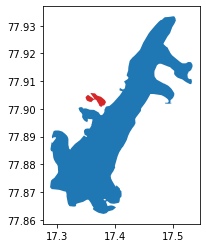

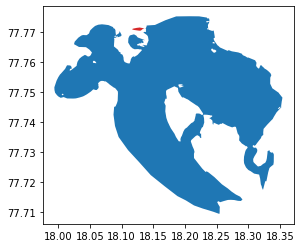

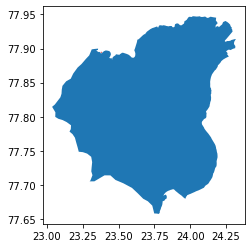

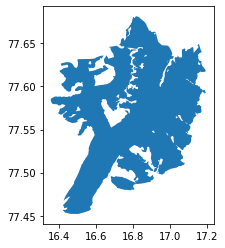

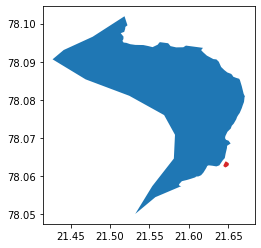

In [45]:
for ids in orphan_f.sort_values(by='area', ascending=False).iloc[:5].anlys_id:
    f, ax = plt.subplots()
    rgi7.loc[rgi7.anlys_id == ids].plot(ax=ax);
    orphan_f.loc[orphan_f.anlys_id == ids].plot(ax=ax, facecolor='C3');